# Multi Label Image Classification

In [1]:
from fastai2.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
import pandas as pd
df = pd.read_csv(path/'train.csv')

In [4]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [7]:
dsets.train[0]

(fname       005023.jpg
 labels            bird
 is_valid         False
 Name: 2515, dtype: object,
 fname       005023.jpg
 labels            bird
 is_valid         False
 Name: 2515, dtype: object)

In [8]:
dblock = DataBlock(get_x= lambda r: r['fname'], get_y= lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('006180.jpg', 'bottle person')

In [9]:
def get_x(r):
    return path/'train'/r['fname']

def get_y(r):
    return r['labels'].split(' ')

In [10]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)

In [11]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=332x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         0., 0.]))

In [12]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['horse','person']

In [13]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[~df['is_valid']].tolist()
    return train,valid

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x,
                  get_y=get_y)

In [15]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [16]:
# create dataloaders
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))

In [17]:
dls = dblock.dataloaders(df)

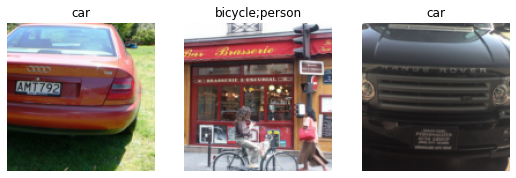

In [18]:
dls.show_batch(nrows=1, ncols=3)

In [19]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [21]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0588, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [23]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [24]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941159,0.671628,0.236205,02:14
1,0.816750,0.532962,0.301479,02:11
2,0.599798,0.182124,0.832767,02:12
3,0.359160,0.104966,0.953999,02:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132266,0.076901,0.964694,02:45
1,0.116835,0.060751,0.973231,02:45
2,0.097295,0.054007,0.976429,02:52


In [25]:
preds,targs = learn.get_preds()

In [26]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9652)

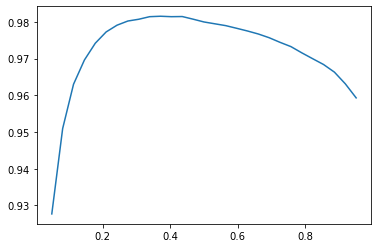

In [27]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);